In [1]:
%pip install tensorflow tqdm pillow matplotlib ipykernel
# tensorrt multiprocess dill

Note: you may need to restart the kernel to use updated packages.


<a target="_blank" href="https://colab.research.google.com/github/naddeoa/yt-data/blob/master/thumbnails.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Set up the model

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import PIL
from typing import List, Dict, Union, Tuple, Optional
import PIL.Image
# from multiprocess import Pool
from functools import partial
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def is_colab():
    try:
        import google.colab
        return True
    except ModuleNotFoundError:
        return False



2023-05-28 22:31:06.089063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  1


2023-05-28 22:31:07.978232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 22:31:07.982382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 22:31:07.982909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Hyper parameters
latent_dim = 100
BATCH_SIZE = 64
learning_rate = 0.0004
beta_1=0.9

In [4]:


# Define the generator network
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(256, input_dim=latent_dim, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(3*64*64, activation='tanh'),
        layers.Reshape((64, 64, 3))
    ])
    return model

# Define the discriminator network
def build_discriminator():
    model = keras.Sequential([
        layers.Flatten(input_shape=(64, 64, 3)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.trainable = False
    return model

# Combine the generator and discriminator into a GAN
def build_gan(generator, discriminator):
    # discriminator.trainable = False
    model = keras.Sequential([
        generator,
        discriminator
    ])
    return model


def process_prediction_image(image):
    # Scale the image from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    # Clip values to [0, 1] in case of any numerical instability
    image = tf.clip_by_value(image, 0, 1)
    # Convert the image tensor to a NumPy array
    return image.numpy()


def visualize_preprocessed_image(image):
    image = process_prediction_image(image)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def visualize_thumbnails(image_list, rows, cols):
    # Create a grid of subplots to display the images
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 10))

    # Iterate over the subplots and plot the generated images
    for i, ax in enumerate(axs.flat):
        # Rescale the pixel values from -1 to 1 to the range 0 to 255
        image = process_prediction_image(image_list[i])
        # image = process_prediction_image(image)
        ax.imshow(image)
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # Show the plot
    plt.show()

def show_samples(generator, latent_dim, rows=1, cols=6):
    noise = tf.random.normal([rows*cols, latent_dim])
    generated_thumbnails = generator.predict(noise)
    # for it in generated_thumbnails:
        # visualize_preprocessed_image(it)
    visualize_thumbnails(generated_thumbnails, rows, cols)



In [5]:

# Define the loss functions
def discriminator_loss(real_output, fake_output):
    # Adversarial loss or binary cross-entropy loss
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    disc_loss = real_loss + fake_loss
    return disc_loss

def generator_loss(fake_output):
    # Adversarial loss or binary cross-entropy loss
    gen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))
    return gen_loss


In [6]:

# Define the optimizero
generator_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)

if is_colab():
    weight_path = "/content/drive/MyDrive/thumbnail-project/weights"
else:
    weight_path = "./model/weights"
    # Make sure model dir exists
    if not os.path.exists("./model"):
        os.mkdir("./model")

# Training loop
@tf.function
def train_step(images,  gan, generator, discriminator):
    noise = tf.random.normal([BATCH_SIZE, latent_dim]) # Defined globally before training

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss  # Return the discriminator loss as batch_loss

def load_weights(gan):
    try:
        gan.load_weights(weight_path)
        print("Loaded previous weights")
    except Exception as e:
        print(e)


def train(dataset, epochs, gan, generator, discriminator):
    # progress_bar_epochs = tqdm(range(epochs), desc='Epochs', position=0)
    load_weights(gan)
    
    for epoch in range(epochs):
        # progress_bar_epochs.update(1)
        
        progress_bar_batches = tqdm(dataset, position=0, leave=False)
        
        for image_batch in progress_bar_batches:
            loss = train_step(image_batch, gan, generator, discriminator)
            
            # progress_bar_batches.update(1)
            progress_bar_batches.set_postfix({'Epoch': epoch, 'Loss': loss})
        
        # progress_bar_batches.close()

        # Update the gan model weights by setting the generator and discriminator weights
        # gan.set_weights(generator.get_weights() + discriminator.get_weights())

        # Get some samples every 20 epochs
        # if epoch % 100 == 0:
        #     show_samples(generator, latent_dim)
        gan.save_weights(weight_path)



    




2023-05-28 22:31:08.175077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 22:31:08.175471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 22:31:08.176001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 22:31:09.484140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-28 22:31:09.484577: I tensorflow/compile

# Download the dataset

In [7]:
import os
import tarfile


if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify the path to the directory containing the TGZ file
    directory_path = "/content/drive/MyDrive/thumbnail-project"

    # List the contents of the directory
    os.listdir(directory_path)



In [8]:
# This might already be done from before


if is_colab():
    # # # Specify the path to the TGZ file
    tgz_file_path = f"{directory_path}/thumbnails.tgz"
    extract_path = '/tmp/thumbnails' # Extract to local dir because I/O is horrible on google drive

    # # # Open the TGZ file
    with tarfile.open(tgz_file_path, 'r:gz') as tar:
        # Extract all files in the TGZ archive
        tar.extractall(path=extract_path)

    extract_data_dir = f'{extract_path}/data'
else:
    extract_data_dir = '/home/anthony/workspace/yt-data/data/'

print(f'Thumbnails in {extract_data_dir}')


Thumbnails in /home/anthony/workspace/yt-data/data/


In [9]:
# List the files in the extracted directory
# extract_path = f'{directory_path}/thumbnails'
file_list = os.listdir(extract_data_dir)
print(file_list[:10])
print(f'Found {len(file_list)} total files')
jpg_file_list = [file for file in file_list if file.endswith(".jpg")]
print(f'Found {len(jpg_file_list)} jpgs')

['v4HLml2Nme8.jpg', 'yDAj48iq4w8.json', 'pE9Qjif6K90.json', 'e1RSD8xLjJ8.json', 'YJKy8FehDUo.json', 'oQkn5feunx0.jpg', 'SzZutCq2-Tc.json', 'qjWLM0DDD_g.json', 'RkZNyux07aQ.json', '_7HvkhauoF8.json']
Found 52214 total files
Found 26107 jpgs


In [10]:

thumbnail_data: List[Tuple[str, str]] = [] # tuples of (path, id)

# Process or use the extracted files
for file_name in jpg_file_list:
    file_path = os.path.join(extract_data_dir, file_name)
    thumbnail_data.append((file_path, file_name.replace('.jpg', '')))

print(thumbnail_data[:10])
print(f'Found {len(thumbnail_data)} thumbnails')

[('/home/anthony/workspace/yt-data/data/v4HLml2Nme8.jpg', 'v4HLml2Nme8'), ('/home/anthony/workspace/yt-data/data/oQkn5feunx0.jpg', 'oQkn5feunx0'), ('/home/anthony/workspace/yt-data/data/IPE-3x3GFWw.jpg', 'IPE-3x3GFWw'), ('/home/anthony/workspace/yt-data/data/kbcshufA-Io.jpg', 'kbcshufA-Io'), ('/home/anthony/workspace/yt-data/data/20aG024pmLc.jpg', '20aG024pmLc'), ('/home/anthony/workspace/yt-data/data/FPYKl2X5xAc.jpg', 'FPYKl2X5xAc'), ('/home/anthony/workspace/yt-data/data/uR58CT3GksQ.jpg', 'uR58CT3GksQ'), ('/home/anthony/workspace/yt-data/data/GVNHqrNFBUA.jpg', 'GVNHqrNFBUA'), ('/home/anthony/workspace/yt-data/data/fmhkZq0NdKY.jpg', 'fmhkZq0NdKY'), ('/home/anthony/workspace/yt-data/data/Ptg2bhLcoRY.jpg', 'Ptg2bhLcoRY')]
Found 26107 thumbnails


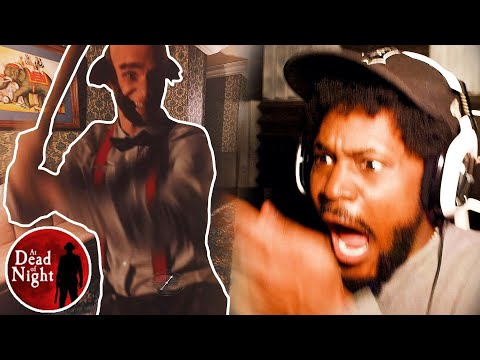

In [11]:
PIL.Image.open(thumbnail_data[0][0])

In [12]:
def load_and_preprocess_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image
        image = tf.image.resize(image, [64, 64])
        image = tf.cast(image, tf.float32)
        image = (image / 255.0)  # Normalize to [0, 1]
        image = (image - 0.5) * 2  # Scale to [-1, 1]
        return image
    except Exception as e:
        print(e)

# Something doesn't work with this
def preprocess_images_parallel(image_paths, num_processes=2):
    progress = tqdm(total=len(image_paths))
    with Pool(4) as pool:
        # results = pool.map(load_and_preprocess_image, image_paths)
        print(f'preprocessing {len(image_paths)} images.')
    # preprocessed_images = list(tqdm(pool.imap(load_and_preprocess_image, image_paths), total=len(image_paths)))
        results = pool.map(load_and_preprocess_image, image_paths)
        print("results")
        print(results)
        progress.close()

    return results


# repeat the first item in thumbnail_data 10 times
bad_data = [load_and_preprocess_image(thumbnail_data[0][0])] * 20000
dataset = bad_data
len(dataset)


# dataset = preprocess_images_parallel([path for path, id in thumbnail_data[0:10]])
# dataset = [load_and_preprocess_image(t[0]) for t in tqdm(thumbnail_data)] 
# dataset

20000

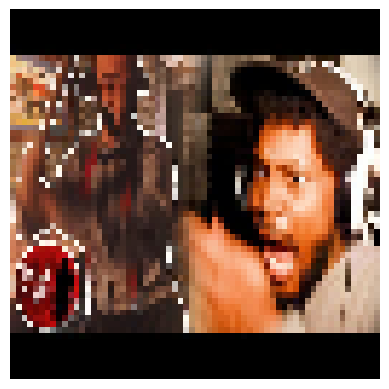

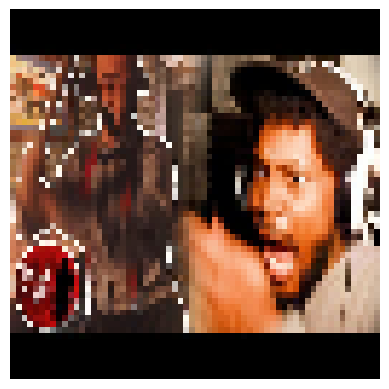

In [13]:
# Make sure the preprocessing worked


for image in dataset[:2]:
    visualize_preprocessed_image(image)


# Train the model

In [14]:


generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)
load_weights(gan)


Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./model/weights


In [15]:
EPOCHS = 10000

# Batch the dataset
batched_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(len(dataset)).batch(BATCH_SIZE)

# Train the GAN
train(batched_dataset, EPOCHS, gan=gan, discriminator=discriminator, generator=generator)


2023-05-28 22:31:12.079001: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./model/weights


  0%|          | 0/313 [00:00<?, ?it/s]2023-05-28 22:31:12.473945: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.
2023-05-28 22:31:12.973250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20000,64,64,3]
	 [[{{node Placeholder/_0}}]]
2023-05-28 22:31:12.973537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [20000,64,64,3]
	 [[{{node Placeholder/_0}}]]
2023-05-28 22:31:14.329742: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f54ebb53b10 initialized 

# Make some stuff


In [ ]:

# Generate new thumbnails using the trained generator
noise = tf.random.normal([30, latent_dim])
generated_thumbnails = generator.predict(noise)



1/1 [==============================] - 0s 67ms/step


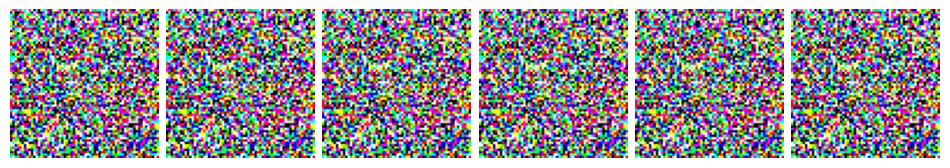

In [23]:
# visualize_thumbnails(generated_thumbnails)
show_samples(generator, latent_dim)